In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import torch
import cv2
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
from glob import glob
import ipywidgets as widgets
import scipy.ndimage as ndimage
import imageio
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go


In [2]:

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'


PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/pip-req-build-f22y41mu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/pip-req-build-f22y41mu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
X_train_1 = np.load("/Volumes/IKBAL/Temiz_dataset/X_train__1.npy")
print(X_train_1.shape)

Y_train_1 = np.load("/Volumes/IKBAL/Temiz_dataset/Y_train__1.npy")
print(Y_train_1.shape)

(25, 58, 256, 256, 3)
(25,)


In [27]:
X_train_11 = np.load("/Volumes/IKBAL/Temiz_dataset/X_train__11.npy")
print(X_train_11.shape)

Y_train_11 = np.load("/Volumes/IKBAL/Temiz_dataset/Y_train__11.npy")
print(Y_train_11.shape)

(25, 58, 256, 256, 3)
(25,)


In [28]:
X_train_13 = np.load("/Volumes/IKBAL/Temiz_dataset/X_train__13.npy")
print(X_train_13.shape)

Y_train_13 = np.load("/Volumes/IKBAL/Temiz_dataset/Y_train__13.npy")
print(Y_train_13.shape)

(25, 58, 256, 256, 3)
(25,)


In [5]:
ex_vol_images = X_train_1[0,:,:,:,:]
print(ex_vol_images.shape)
ex_slice_img = ex_vol_images[28,:,:,:]
print(ex_slice_img.shape)

(58, 256, 256, 3)
(256, 256, 3)


In [204]:
np.max(ex_vol_images)

1.0

In [7]:
m0, m1, m2, m3 = ex_vol_images.shape
# Add a slider that starts with 0 and ends at the number of
# slices along the axial plane, n0=99.
@widgets.interact(axial_slice=(0,m0-1))
# Define the function that shows the images of the specified slice number.
# It starts with the 10th slice. And you can scroll over any slice
# using the slider.

def axial_slicer(axial_slice=50):
  
  # Show the image of the specified slice number in 'gray' color-map
  # and axial aspect ratio
  
  plt.imshow(ex_vol_images[axial_slice,:,:,:])
  #plt.imshow(mosaic_pictures_vol[axial_slice,:,:], cmap='hot')
  #plt.imshow(mosaic_pictures_vol[axial_slice,:,:], cmap='RdBu')


  # Don't show the axis
  plt.axis('off')
  plt.title("Mosic Pictures")

interactive(children=(IntSlider(value=50, description='axial_slice', max=57), Output()), _dom_classes=('widget…

In [206]:
np.max(ex_slice_img)

1.0

In [8]:
image_for_mask = (ex_slice_img * 255).round().astype(np.uint8)

### Selecting Object with SAM


First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [10]:
predictor.set_image(image_for_mask)

In [15]:
input_point = np.array([[128, 150]])
input_label = np.array([1])


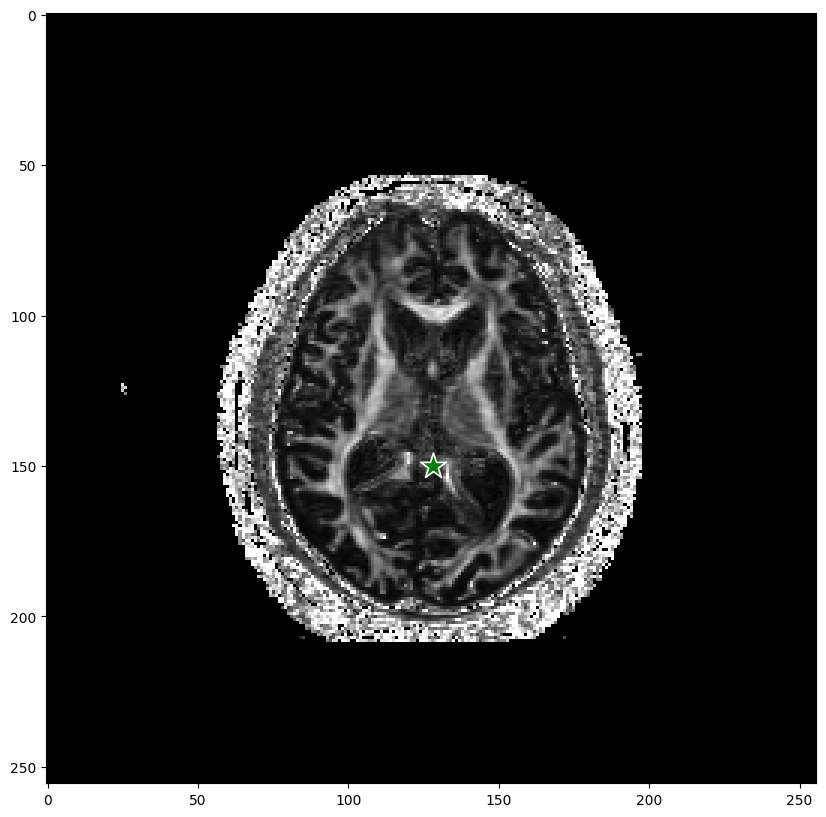

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image_for_mask)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [212]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

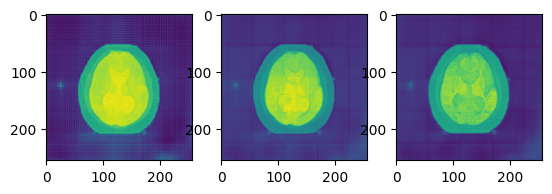

In [213]:
plt.subplot(1,3,1)
plt.imshow(logits[0,:,:])

plt.subplot(1,3,2)
plt.imshow(logits[1,:,:])

plt.subplot(1,3,3)
plt.imshow(logits[2,:,:])


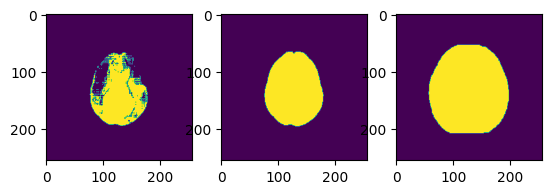

In [214]:

plt.subplot(1,3,1)
plt.imshow(masks[0,:,:]) # True or False values are  determined

plt.subplot(1,3,2)
plt.imshow(masks[1,:,:])

plt.subplot(1,3,3)
plt.imshow(masks[2,:,:])


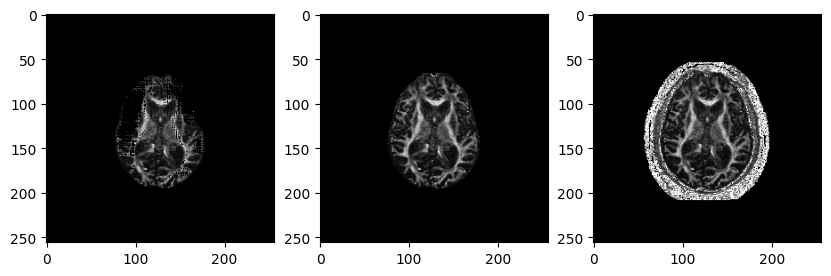

In [224]:
masked_image = np.ones(ex_slice_img.shape)
masked_image.shape

masked_image[:,:,0] = ex_slice_img[:,:,0] * masks[0,:,:] 
masked_image[:,:,1] = ex_slice_img[:,:,1] * masks[0,:,:] 
masked_image[:,:,2] = ex_slice_img[:,:,2] * masks[0,:,:] 



masked_image1 = np.ones(ex_slice_img.shape)
masked_image1.shape

masked_image1[:,:,0] = ex_slice_img[:,:,0] * masks[1,:,:] 
masked_image1[:,:,1] = ex_slice_img[:,:,1] * masks[1,:,:] 
masked_image1[:,:,2] = ex_slice_img[:,:,2] * masks[1,:,:]



masked_image2 = np.ones(ex_slice_img.shape)
masked_image2.shape

masked_image2[:,:,0] = ex_slice_img[:,:,0] * masks[2,:,:]
masked_image2[:,:,1] = ex_slice_img[:,:,1] * masks[2,:,:] 
masked_image2[:,:,2] = ex_slice_img[:,:,2] * masks[2,:,:] 



plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(masked_image[:,:,:]) # True or False values are  determined

plt.subplot(1,3,2)
plt.imshow(masked_image1[:,:,:])

plt.subplot(1,3,3)
plt.imshow(masked_image2[:,:,:])

In [223]:
x = input()
print(x)

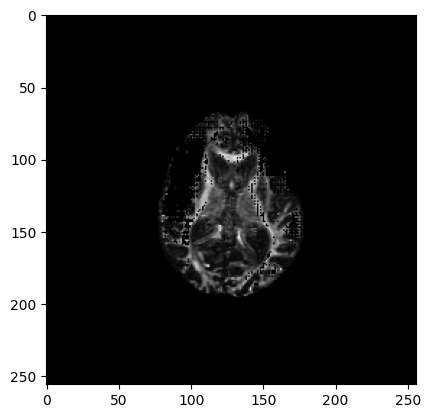

In [220]:
plt.imshow(masked_image[:,:,:])

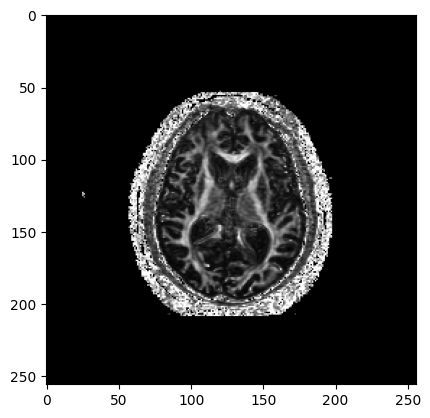

In [221]:
plt.imshow(image_for_mask[:,:,:])